In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
data = np.array([4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4])

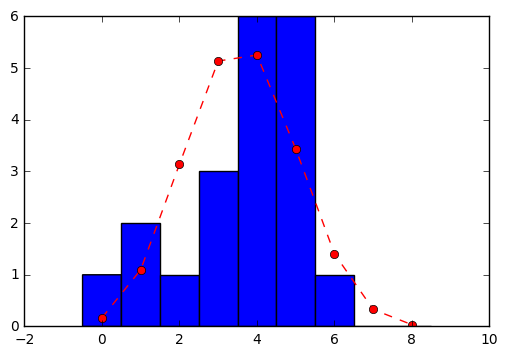

In [3]:
x = np.arange(0,9,1)
true_distribution = stats.binom.pmf(x,8,0.45)*data.shape[0]
plt.hist(data,bins=np.arange(-0.5,9.1))
plt.plot(x,true_distribution,'--o',c='r')

In [4]:
const = np.ones(data.shape[0])
model = sm.GLM(np.array([data,8-data]).T,const,
               family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                   20
Model:                            GLM   Df Residuals:                       19
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -37.748
Date:                Sun, 05 Feb 2017   Deviance:                       28.722
Time:                        00:15:26   Pearson chi2:                     24.5
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1754      0.159     -1.105      0.269        -0.487     0.136
==============================================================================
"""

In [5]:
q_estimate = 1 / (1 + np.exp(-result.params[0]))
q_estimate

0.45624999999999993

In [6]:
a = np.arange(0.01,1.0,0.01)
llh = np.array([np.sum(stats.binom.logpmf(data,8,p)) for p in a])

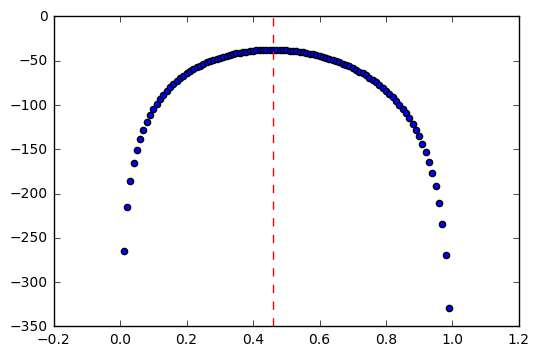

In [7]:
plt.scatter(a,llh)
plt.axvline(a[np.argmax(llh)],ls='--',c='r')

In [8]:
a[np.argmax(llh)]

0.46000000000000002

In [9]:
def series_llf(q,steps=100):
    series = [[0,q]]
    llh = np.sum(stats.binom.logpmf(data,8,q))
    for i in range(steps):
        random = np.random.randint(2)
        if random == 1:
            cal = stats.binom.logpmf(data,8,q+0.01).sum()
            if llh < cal:
                llh = cal
                q += 0.01
        else:
            cal = stats.binom.logpmf(data,8,q-0.01).sum()
            if llh < cal:
                llh = cal
                q -= 0.01
        
        series.append([i+1,q])
        
    return np.array(series)    

In [10]:
init_3 = series_llf(0.3)
init_6 = series_llf(0.6)

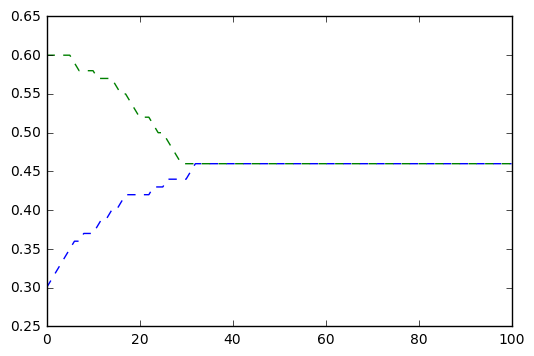

In [11]:
plt.plot(init_3[:,0],init_3[:,1],'--')
plt.plot(init_6[:,0],init_6[:,1],'--')

In [12]:
def metro_police(q,size=1000):
    llh = stats.binom.logpmf(data,8,q).sum()
    series = [[0,q,llh]]
    for i in range(size):
        random = np.random.randint(2)
        if random == 1:
            new_llh = stats.binom.logpmf(data,8,q+0.01).sum()
            if llh < new_llh:
                llh = new_llh
                q += 0.01
            elif np.random.rand() < np.exp(new_llh - llh):
                llh = new_llh
                q += 0.01
        else:
            new_llh = stats.binom.logpmf(data,8,q-0.01).sum()
            if llh < new_llh:
                llh = new_llh
                q -= 0.01
            elif np.random.rand() < np.exp(new_llh - llh):
                llh = new_llh
                q -= 0.01
        
        series.append([i+1,q,llh])
        
    return np.array(series)

init_3_100 = metro_police(0.3,100)
init_3_1000 = metro_police(0.3,1000)
init_3_10000 = metro_police(0.3,10000)

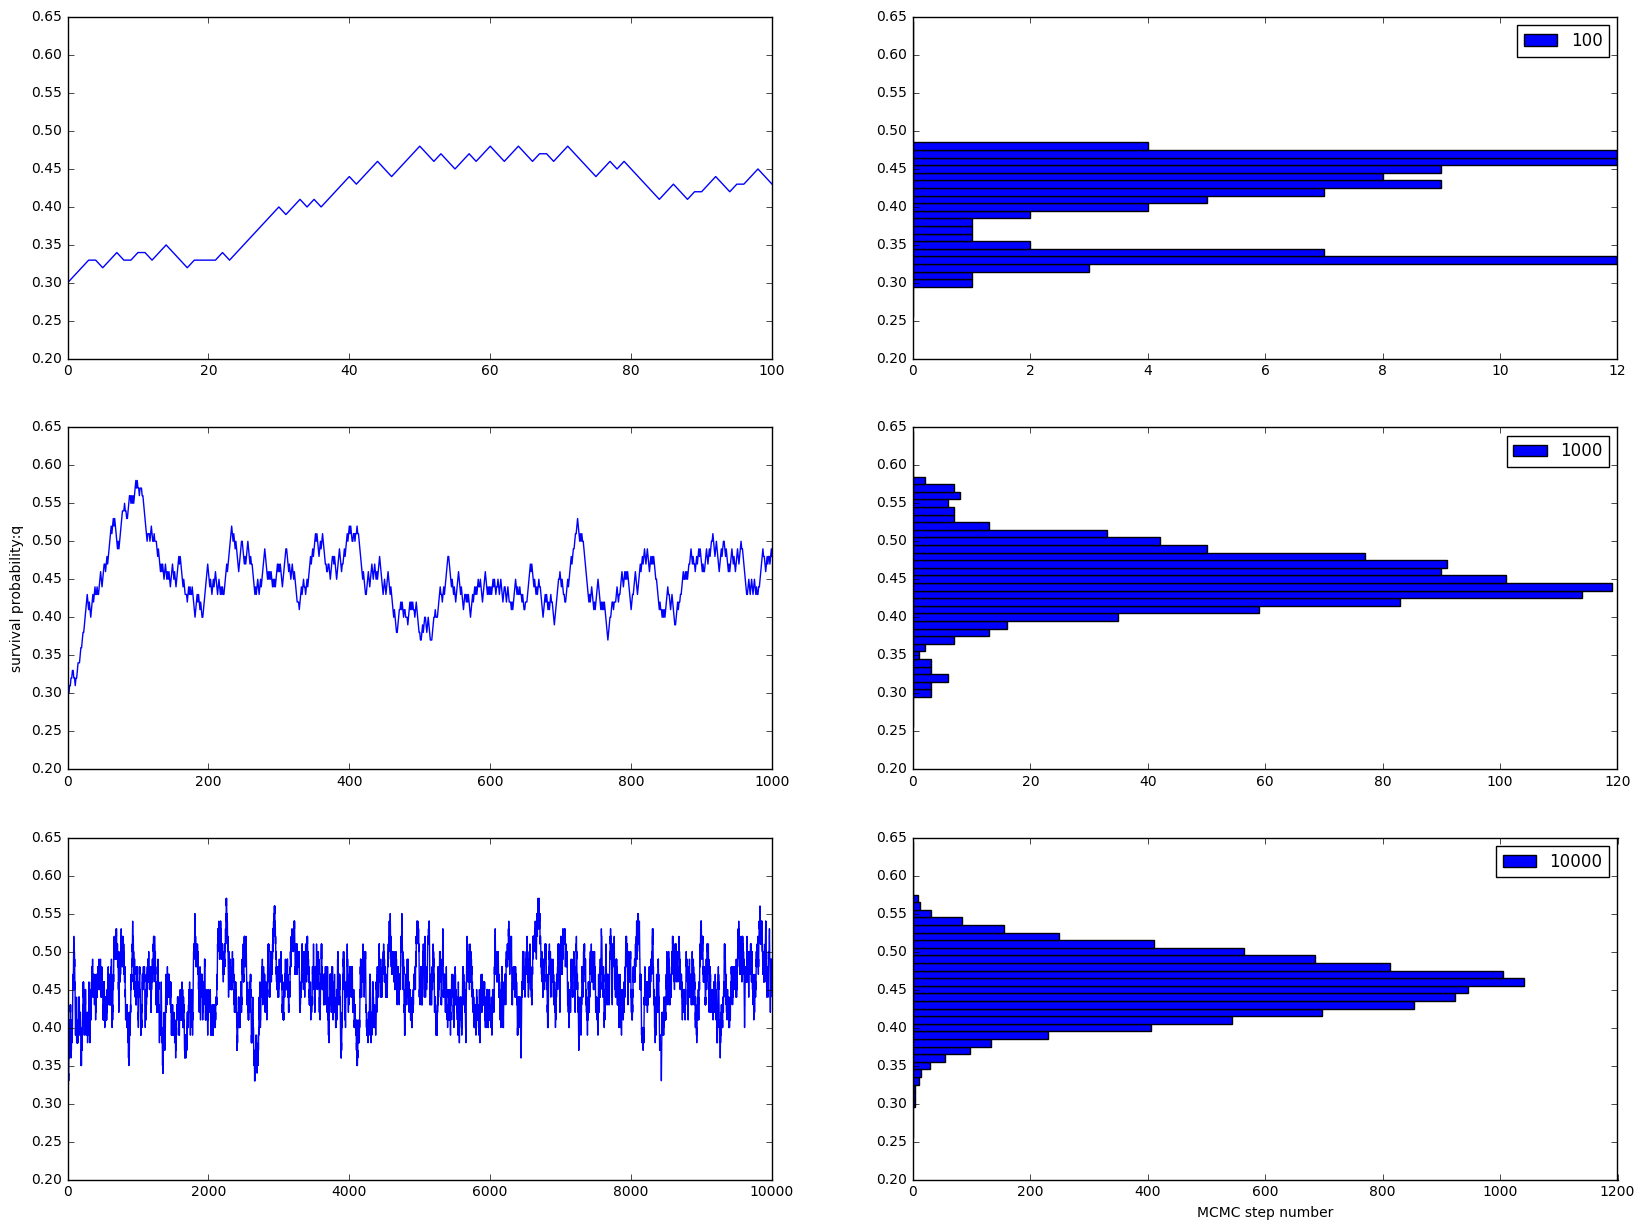

In [13]:
fig,ax = plt.subplots(3,2,figsize=(20,15))
steps = [init_3_100,init_3_1000,init_3_10000]
for i,step in enumerate(steps):
    ax[i][0].plot(step[:,0],step[:,1])
    ax[i][0].set_ylim((0.2,0.65))
    ax[i][1].hist(step[:,1],orientation='horizontal',bins=np.arange(0.245,0.655,0.01),label=str(step.shape[0]-1))
    ax[i][1].legend()
ax[1][0].set_ylabel('survival probability:q')
ax[2][1].set_xlabel('MCMC step number')

In [14]:
y = np.arange(0.25,0.66,0.01)
llh = np.array([np.sum(stats.binom.logpmf(data,8,q)) for q in y])
lh = np.exp(llh)
P_q_y = lh / lh.sum()

(array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.029997  ,   0.029997  ,   0.039996  ,
          0.09999   ,   0.129987  ,   0.289971  ,   0.53994601,
          0.96990301,   1.32986701,   2.29977002,   4.04959504,
          5.43945605,   6.95930407,   8.53914609,   9.23907609,
          9.45905409,  10.3989601 ,  10.0489951 ,   8.12918708,
          6.83931607,   5.63943606,   4.10958904,   2.47975202,
          1.54984502,   0.83991601,   0.309969  ,   0.119988  ,
          0.089991  ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]),
 array([ 0.245,  0.255,  0.265,  0.275,  0.285,  0.295,  0.305,  0.315,
         0.325,  0.335,  0.345,  0.355,  0.365,  0.375,  0.385,  0.395,
         0.405,  0.415,  0.425,  0.435,  0.445,  0.455,  0.465,  0.475,
         0.485,  0.495,  0.505,  0.515,  0.525,  0.535,  0.545,  0.555,
         0.565,  0.575,  0.585,  0.595,  0.605,  0.615,  0.625,  0.635

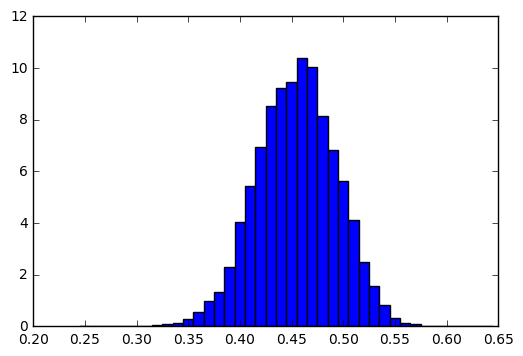

In [23]:
plt.hist(init_3_10000[:,1],bins=np.arange(0.245,0.655,0.01),normed=True)

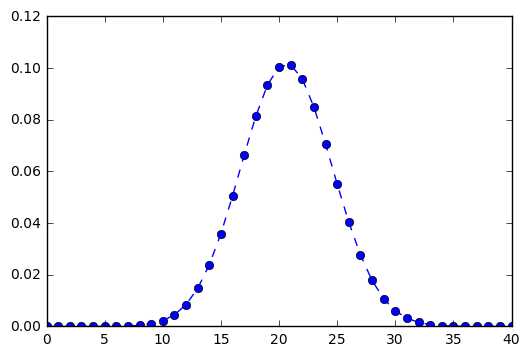

In [17]:
plt.plot(P_q_y,'--o')

In [19]:
P_q_y,

(array([  1.21925171e-08,   6.64288670e-08,   3.19732248e-07,
          1.36963960e-06,   5.25621368e-06,   1.81770710e-05,
          5.69399880e-05,   1.62317988e-04,   4.22832414e-04,
          1.01024373e-03,   2.22112036e-03,   4.50695394e-03,
          8.46245722e-03,   1.47374507e-02,   2.38536469e-02,
          3.59485169e-02,   5.05230291e-02,   6.63096088e-02,
          8.13677914e-02,   9.34429542e-02,   1.00510242e-01,
          1.01326174e-01,   9.57827080e-02,   8.49266614e-02,
          7.06418379e-02,   5.51243550e-02,   4.03482446e-02,
          2.76932907e-02,   1.78153742e-02,   1.07354104e-02,
          6.05491232e-03,   3.19338773e-03,   1.57312389e-03,
          7.22894003e-04,   3.09410617e-04,   1.23141191e-04,
          4.54822137e-05,   1.55563987e-05,   4.91533284e-06,
          1.43086445e-06,   3.82593617e-07]),)